# Quantitative Exercise

The goal of this notebook is to practice quantitative data analysis using Numenta Anomaly Benchmark (NAB) dataset on Streaming Outlier Detection algorithm, in particular on SPOT (add reference). We will use three different datasets comprising of data retrieved from real world. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

## Load Data

We load the data directly from the csv files in pandas DataFrames, we check if there are some missing values and finally print a sample of the data

In [2]:
df = pd.read_csv('./data/cpu_utilization.csv')

In [3]:
print("Missing values: ", df.isnull().values.any())

Missing values:  False


In [4]:
df.head()

,timestamp,value
0,2014-05-14 01:14:00,85.835
1,2014-05-14 01:19:00,88.167
2,2014-05-14 01:24:00,44.595
3,2014-05-14 01:29:00,56.282
4,2014-05-14 01:34:00,36.534


## Exploratory Data Analysis

In this section we will explore the data in more detail. Firstly, we will plot data with different view to understand our dataset. Secondly, we will run our dataset over the SPOT algorithm to find outliers and derive more insights
### Descriptive Plotting

Basics dataset statistics

In [5]:
df.describe()

,value
count,18050.000000
mean,38.282756
std,15.639294
min,11.529000
25%,30.789000
50%,32.001000
75%,35.660500
max,100.000000


The dataset contains temperature data for a time period of 2 months

In [6]:
print(df['timestamp'].min())
print(df['timestamp'].max())

2014-05-14 01:14:00
2014-07-15 17:19:00


Convert data in the right format, DateTime type and values in Celsius

In [7]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

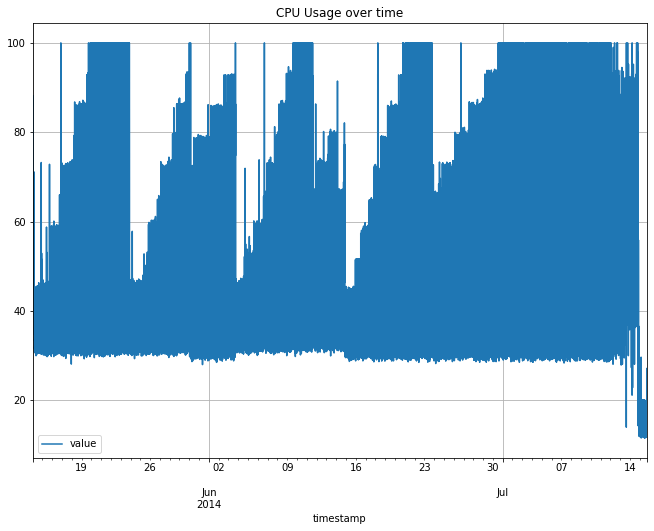

In [8]:
df.plot(x='timestamp', y='value', figsize=(11,8), title='CPU Usage over time', grid=True)

In [9]:
df = df.set_index('timestamp')
df.index
df.sort_index(inplace=True)

Decomposing time series into components for further analysis, modeled as additive. 

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

additive = seasonal_decompose(df, model='additive', freq=2)
additive_df = pd.concat([additive.seasonal, additive.trend, additive.resid, additive.observed], axis=1)
additive_df.columns = ['seasonal', 'trend', 'resid', 'actual_values']
additive_df.head()

,seasonal,trend,resid,actual_values
timestamp,,,,
2014-05-14 01:14:00,-1.925248,NaN,NaN,85.835
2014-05-14 01:19:00,1.925248,76.69100,9.550752,88.167
2014-05-14 01:24:00,-1.925248,58.40975,-11.889502,44.595
2014-05-14 01:29:00,1.925248,48.42325,5.933502,56.282
2014-05-14 01:34:00,-1.925248,41.56100,-3.101752,36.534


Text(0.5, 0.98, 'Additive Decompose')

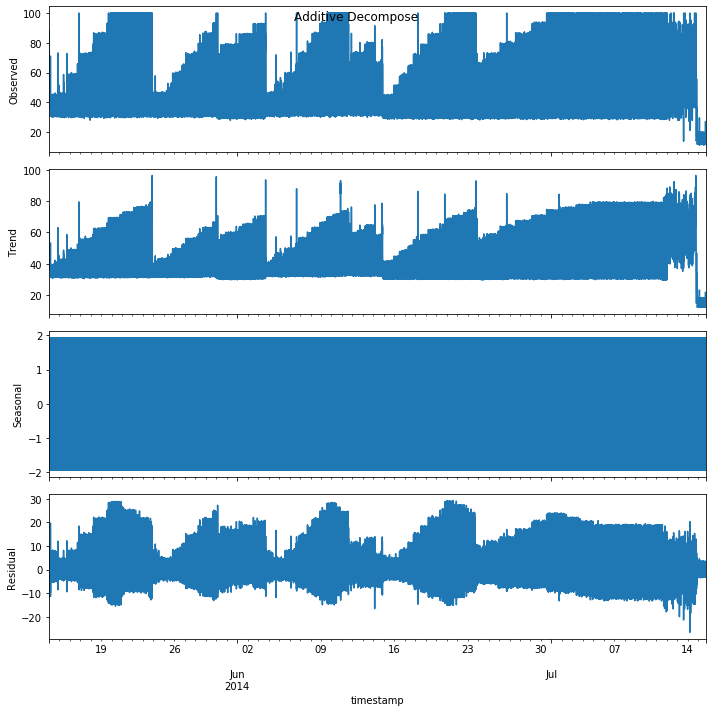

In [11]:
plt.rcParams.update({'figure.figsize': (10,10)})
additive.plot().suptitle('Additive Decompose')

In [12]:
df.reset_index(inplace=True)
df.head()

,timestamp,value
0,2014-05-14 01:14:00,85.835
1,2014-05-14 01:19:00,88.167
2,2014-05-14 01:24:00,44.595
3,2014-05-14 01:29:00,56.282
4,2014-05-14 01:34:00,36.534


In [13]:
df['year'] = df['timestamp'].apply(lambda x : x.year)
df['month'] = df['timestamp'].apply(lambda x : x.month)
df['day'] = df['timestamp'].apply(lambda x : x.day)
df['hour'] = df['timestamp'].apply(lambda x : x.hour)
df['minute'] = df['timestamp'].apply(lambda x : x.minute)

df.index = df['timestamp']
df.drop(['timestamp'], axis=1, inplace=True)
df.head(3)

,value,year,month,day,hour,minute
timestamp,,,,,,
2014-05-14 01:14:00,85.835,2014,5,14,1,14
2014-05-14 01:19:00,88.167,2014,5,14,1,19
2014-05-14 01:24:00,44.595,2014,5,14,1,24


In [14]:
weekly = df['value'].resample('W').mean()
monthly = df['value'].resample('M').mean()
daily = df['value'].resample('D').mean()

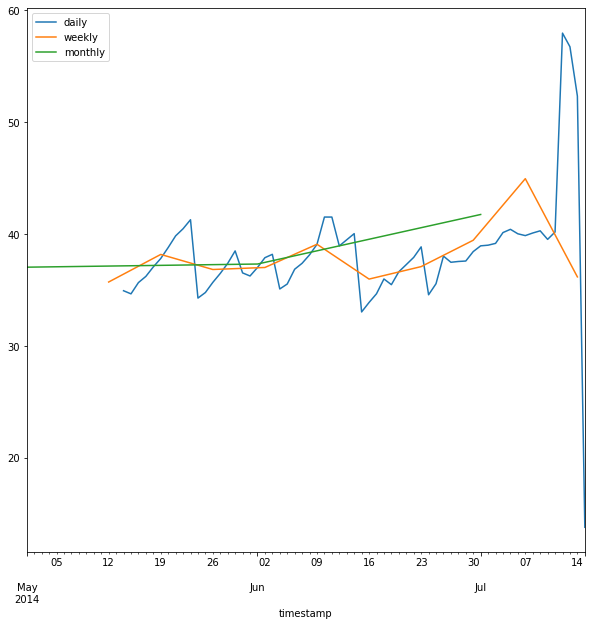

In [15]:
daily.plot()
weekly.plot()
monthly.plot()
plt.legend(["daily", "weekly", "monthly"])

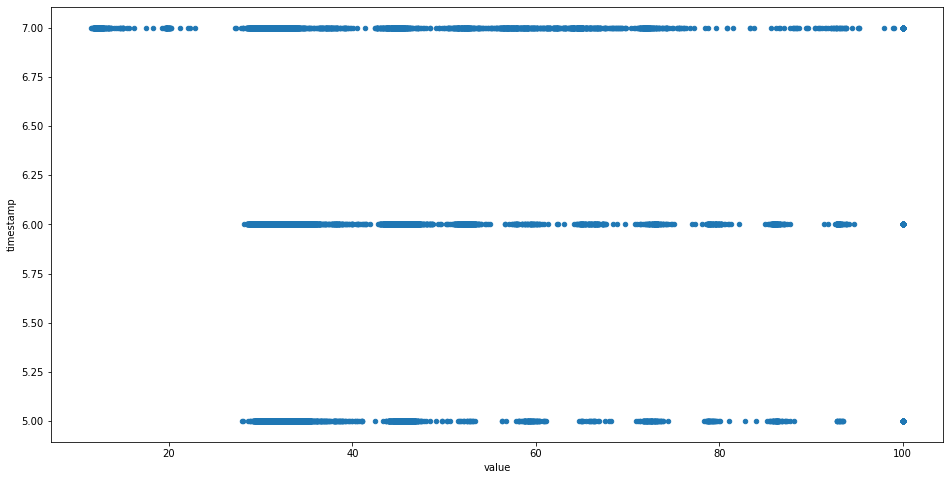

In [16]:
df_2 = pd.read_csv('./data/cpu_utilization.csv')
mon = df_2['timestamp']
temp = pd.DatetimeIndex(mon)
months = pd.Series(temp.month)
to_plot = df_2.drop(['timestamp'], axis=1)
to_plot = to_plot.join(months)

to_plot.plot.scatter(x='value',y='timestamp', figsize=(16,8))
plt.show()

# Outlier detection with SPOT

The next step of this quantitative exercise is the research and the study of the outliers. We decided to find the outliers through SPOT algorithm, so after having imported the common libraries, we imported the spot class. In our dataset the indipendent variable is the timestamp in which the cpu usage is measured. The value of the cpu usage is our dependent variable because it changes over time. Other two dependent variables are the lower and the upper thresholds. They depend not only on the time, but also on the previous values of the cpu usage. Our expectation in this part of the analysis is to find some outliers that are caused by sudden increments or decrements of the cpu usage.

In [17]:
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib as mpl
import tqdm as tqdm
import matplotlib.pyplot as plt
from model import spot

After having loaded the original dataset, we splitted the timestamp column in date and time in order to have the possibility of creating intervals based on the date. Due to the fact that the 15st May 2014 is in the middle of the dataset, we decided to split the data around this date. The data before the 15st May 2014 are used as initial batch, while the data after are used as streaming data.

In [18]:
f = 'https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/cpu_utilization_asg_misconfiguration.csv'

P = pd.read_csv(f)

P[['date', 'time']] = P['timestamp'].str.split(' ', 1, expand=True)

P['date'] = pd.to_datetime(P['date'])
# stream
u_data = (P['date'] >= '2014-05-15')# & (P['date'] < '2014-05-21')
data = P['value'][u_data].values

# initial batch
u_init_data = (P['date'] < '2014-05-15')
init_data = P['value'][u_init_data].values

We set the parameters, initialize the SPOT algorithm and run it. The results are shown in a temporal graph, in which we can see the lower and the upper thresholds in orange, the time series data in blue and the outliers as red points.

Initial threshold : {'up': 14.412399999999991, 'down': -9.45170000000002}
Number of peaks : {'up': 5, 'down': 5}
Grimshaw maximum log-likelihood estimation ... [done]
	          Parameters               Upper               Lower
	------------------------------------------------------------
	                   γ                0.00                0.00
	                   σ               10.72                1.25
	          likelihood               16.86                6.13
	    Extreme quantile               95.33              -18.90
	------------------------------------------------------------


100%|███████████████████████████████████| 17776/17776 [01:25<00:00, 208.91it/s]


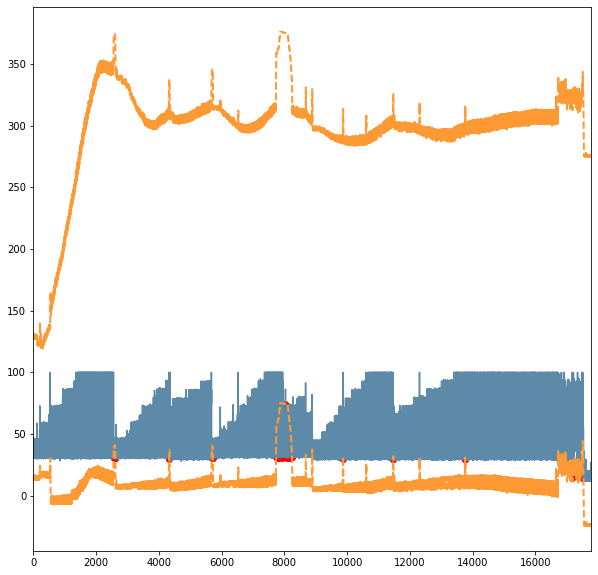

In [19]:
q = 1e-5 			# risk parameter
d = 10				# depth
s = spot.bidSPOT(q,d) 	# bidSPOT object
s.fit(init_data,data) 	# data import
s.initialize() 			# initialization step
results = s.run() 	# run
s.plot(results) 		   # plot

We are intersted only in the data that had been streamed and in particular in the outliers that has been found. So we select only the streamed data and we describe them. We also compute the mean of the thresholds and of the time series.

In [20]:
df = P[u_data]
df.describe()

,value
count,17776.000000
mean,38.334364
std,15.726336
min,11.529000
25%,30.783750
50%,32.000000
75%,35.666000
max,100.000000


In [21]:
from statistics import mean
print("mean of lower threshold : "+ str(mean(results['lower_thresholds'])))
print("mean of cpu usage : "+ str(mean(df['value'])))
print("mean of upper threshold : "+ str(mean(results['upper_thresholds'])))

mean of lower threshold : 12.664299012943752
mean of cpu usage : 38.334364350810084
mean of upper threshold : 298.6025879070889


After that, we take only the outliers and we visualize and describe them.

In [22]:
out = df.iloc[results['alarms']]
display(out)

,timestamp,value,date,time
2836,2014-05-23 21:34:00,31.9345,2014-05-23,21:34:00
2837,2014-05-23 21:39:00,31.2860,2014-05-23,21:39:00
2838,2014-05-23 21:44:00,33.1478,2014-05-23,21:44:00
2839,2014-05-23 21:49:00,32.6650,2014-05-23,21:49:00
2840,2014-05-23 21:54:00,31.8340,2014-05-23,21:54:00
...,...,...,...,...
17795,2014-07-14 20:09:00,14.8390,2014-07-14,20:09:00
17796,2014-07-14 20:14:00,14.7130,2014-07-14,20:14:00
17797,2014-07-14 20:19:00,14.2860,2014-07-14,20:19:00
17798,2014-07-14 20:24:00,18.2140,2014-07-14,20:24:00


In [23]:
out.describe()

,value
count,594.000000
mean,35.919694
std,8.363774
min,13.999000
25%,32.117750
50%,33.031000
75%,34.936000
max,74.146000


We are interested only in outliers, so we create a column in the dataframe that is equal to 1 if the row represents an outlier, 0 otherwise.

In [24]:
df['outlier'] = 0
for a in results['alarms']:
    df['outlier'].iloc[a] = 1
display(df[df['outlier']==1])

C:\Users\Matteo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Matteo\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Matteo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/use

,timestamp,value,date,time,outlier
2836,2014-05-23 21:34:00,31.9345,2014-05-23,21:34:00,1
2837,2014-05-23 21:39:00,31.2860,2014-05-23,21:39:00,1
2838,2014-05-23 21:44:00,33.1478,2014-05-23,21:44:00,1
2839,2014-05-23 21:49:00,32.6650,2014-05-23,21:49:00,1
2840,2014-05-23 21:54:00,31.8340,2014-05-23,21:54:00,1
...,...,...,...,...,...
17795,2014-07-14 20:09:00,14.8390,2014-07-14,20:09:00,1
17796,2014-07-14 20:14:00,14.7130,2014-07-14,20:14:00,1
17797,2014-07-14 20:19:00,14.2860,2014-07-14,20:19:00,1
17798,2014-07-14 20:24:00,18.2140,2014-07-14,20:24:00,1


As we have seen when we have shown the oulier rows, most of the outliers happened on 10th, 11th and 12th June 2014, so now a focus on that week is shown. During these days, the cpu usage is decreased and the lower threshold is increased and so they resulted as outliers. Our initial expectation has been satisfied. In order to better visualize the outliers, we do not show anymore the thresolds so that it is possible to focus our attention on the red points.

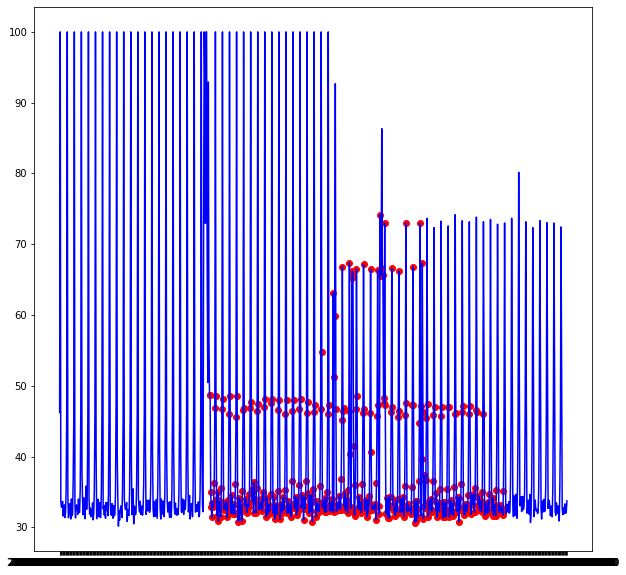

In [26]:
fig, ax = plt.subplots()

df2 = df[(df['date'] >= '2014-06-10') & (df['date'] <= '2014-06-12')]

a = df2.loc[df2['outlier'] == 1, ['timestamp', 'value']] #anomaly

ax.plot(df2['timestamp'], df2['value'], color='blue')
ax.scatter(a['timestamp'],a['value'], color='red')
plt.show()

Finally, we want to visualize the frequence of outliers based on the value of the cpu usage.

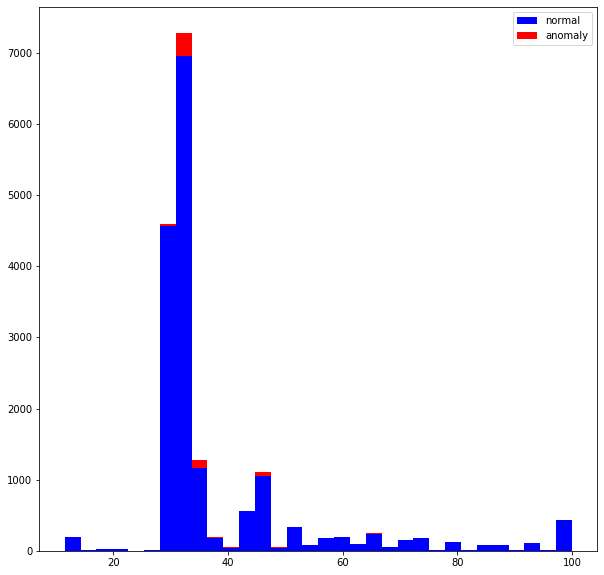

In [27]:
a = df.loc[df['outlier'] == 0, 'value']
b = df.loc[df['outlier'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()